In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import seaborn as sns
from modules.stats import *
from modules.PCA import *
from modules.LDA import *
from modules.read_data import *
from modules.LR import *
from modules.ROC import *
from modules.LR import *
from modules.KNN import *
from modules.DTW import *
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense

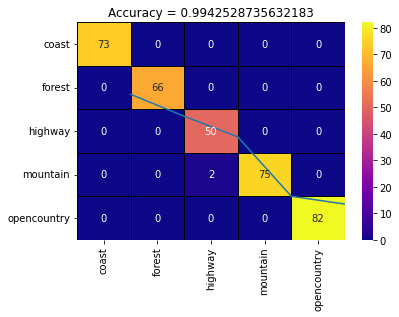

In [4]:
path = 'Assets/Image Dataset'
data_class = ['coast', 'forest', 'highway', 'mountain', 'opencountry']

C = [] #36*23
D = []

for i in data_class:
	t = read_ID(path, i, 'train').flatten().reshape(-1, 36*23)
	d = read_ID(path, i, 'dev').flatten().reshape(-1, 36*23)
	C.append((t - t.min(axis = 0))/(t.max(axis=0) - t.min(axis=0)))
	D.append((d - t.min(axis = 0))/(t.max(axis=0) - t.min(axis=0)))
C_y = []
D_y = []

for i in range(5):
	C_y.append(i * np.ones(C[i].shape[0]))
	D_y.append(i * np.ones(D[i].shape[0]))
X =  np.concatenate(C, axis=0)
X_d = np.concatenate(D, axis=0)
Y = np.concatenate(C_y, axis=0)
Y_d = np.concatenate(D_y, axis=0)
pca = False
lda = False
lda = ~pca & lda #if pca is true then lda is false
if pca:
	pc = 25
	μ, Σ = stats(X)
	eigval, Q = PCA(Σ, pc)
	X = X @ Q
	X_d = X_d @ Q
if lda:
	pc = 25
	μ, Σ = stats(X)
	μk = []
	for c in range(5):
		μk.append(stats(X[Y == c])[0])
	μk = np.array(μk)
	v = LDA(X,Y,μ,μk,pc)
	X = np.abs(X @ v)
	X_d = np.abs(X_d @ v)
if pca or lda:	
	C_new = []
	D_new = []
	nc=0
	nd=0
	for i in range(5):
		c = X[nc:nc+C[i].shape[0]]
		d = X_d[nd:nd+D[i].shape[0]]
		C_new.append(c)
		D_new.append(d)
		nc += C[i].shape[0]
		nd += D[i].shape[0]
	D = D_new
	C = C_new
train_data = C; total_train = X 
dev_data = D; total_dev = X_d
#training LR
loss_steps, w_ml = gradient_descent(train_data)

#error vs iter 
plt.plot(loss_steps['step'], loss_steps['error'])
plt.xlabel('step'); plt.ylabel('error')

#making prediction
p = softmax(- total_dev @ w_ml, axis=1)
t = np.argmax(p, axis=1)

P = []
for c in range(5):
    s = dev_data[c].shape[0]
    P.append(t[:s])
    t = np.delete(t, slice(s), 0)
y_pred = np.concatenate(P)
cm = confusion_matrix(y_pred, Y_d)
accuracy = accuracy_score(Y_d,y_pred)
ax = sns.heatmap(cm, annot = True, cmap ='plasma',linecolor ='black', linewidths = 1, fmt = '.0f', xticklabels = data_class, yticklabels = data_class)
ax.set_title(f'Accuracy = {accuracy}')
TPR_i1 = 0; FPR_i1 = 0
for c in range(5):
	tpr, fpr = ROC(label_binarize(Y_d, classes=[0,1,2,3,4])[:,c], p[:,c])
	TPR_i1 += tpr/5
	FPR_i1 += fpr/5

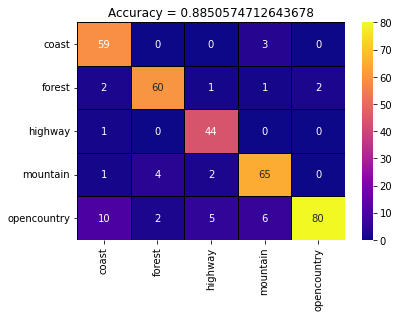

In [5]:
path = 'Assets/Image Dataset'
data_class = ['coast', 'forest', 'highway', 'mountain', 'opencountry']

C = [] #36*23
D = []

for i in data_class:
	t = read_ID(path, i, 'train').flatten().reshape(-1, 36*23)
	d = read_ID(path, i, 'dev').flatten().reshape(-1, 36*23)
	C.append((t - t.min(axis = 0))/(t.max(axis=0) - t.min(axis=0)))
	D.append((d - t.min(axis = 0))/(t.max(axis=0) - t.min(axis=0)))
C_y = []
D_y = []

for i in range(5):
	C_y.append(i * np.ones(C[i].shape[0]))
	D_y.append(i * np.ones(D[i].shape[0]))
X =  np.concatenate(C, axis=0)
X_d = np.concatenate(D, axis=0)
Y = np.concatenate(C_y, axis=0)
Y_d = np.concatenate(D_y, axis=0)
pca = False
lda = False
lda = ~pca & lda #if pca is true then lda is false
if pca:
	pc = 25
	μ, Σ = stats(X)
	eigval, Q = PCA(Σ, pc)
	X = X @ Q
	X_d = X_d @ Q
if lda:
	pc = 25
	μ, Σ = stats(X)
	μk = []
	for c in range(5):
		μk.append(stats(X[Y == c])[0])
	μk = np.array(μk)
	v = LDA(X,Y,μ,μk,pc)
	X = np.abs(X @ v)
	X_d = np.abs(X_d @ v)
if pca or lda:	
	D_new = []
	nd=0
	for i in range(5):
		d = X_d[nd:nd+D[i].shape[0]]
		D_new.append(d)
		nd += D[i].shape[0]
	D = D_new
##KNN implementation
total_train = X; dev_data = D
kn = 15
prediction = []
P = []
for c in range(5):
	p = np.zeros(dev_data[c].shape[0])
	a = np.zeros((dev_data[c].shape[0], 5))
	for i in range(dev_data[c].shape[0]):
		p[i] = KNN(dev_data[c][i], total_train, Y, kn)[0]
		A = KNN(dev_data[c][i], total_train, Y, kn)[1]
		a[i] = np.array([(A==0).sum()/kn, (A==1).sum()/kn, (A==2).sum()/kn, (A==3).sum()/kn, (A==4).sum()/kn])
	prediction.append(p)
	P.append(a)
P = np.concatenate(P)
y_pred = np.concatenate(prediction)
cm = confusion_matrix(y_pred, Y_d)
accuracy = accuracy_score(Y_d,y_pred)
ax = sns.heatmap(cm, annot = True, cmap ='plasma',linecolor ='black', linewidths = 1, fmt = '.0f', xticklabels = data_class, yticklabels = data_class)
ax.set_title(f'Accuracy = {accuracy}')
TPR_i2 = 0; FPR_i2 = 0
for c in range(5):
	tpr, fpr = ROC(label_binarize(Y_d, classes=[0,1,2,3,4])[:,c], P[:,c])
	TPR_i2 += tpr/5
	FPR_i2 += fpr/5


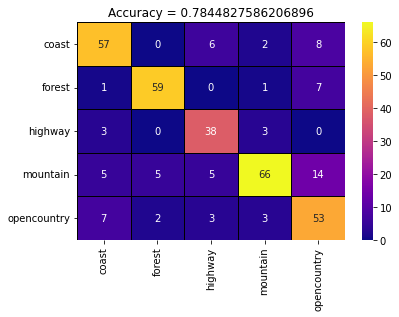

In [6]:
path = 'Assets/Image Dataset'
data_class = ['coast', 'forest', 'highway', 'mountain', 'opencountry']

C = [] #36*23
D = []

for i in data_class:
	C.append(read_ID(path, i, 'train').flatten().reshape(-1, 36*23))
	D.append(read_ID(path, i, 'dev').flatten().reshape(-1, 36*23))
C_y = []
D_y = []

for i in range(5):
	C_y.append(i * np.ones(C[i].shape[0]))
	D_y.append(i * np.ones(D[i].shape[0]))
train = np.concatenate(C, axis=0)
dev = np.concatenate(D, axis=0)

X = (train - train.min(axis=0))/(train.max(axis=0) - train.min(axis=0))
X_d = (dev - dev.min(axis=0))/(dev.max(axis=0) - dev.min(axis=0))
Y = np.concatenate(C_y, axis=0)
Y_d = np.concatenate(D_y, axis=0)
pca = False
lda = False
lda = ~pca & lda #if pca is true then lda is false
if pca:
	pc = 25
	μ, Σ = stats(X)
	eigval, Q = PCA(Σ, pc)
	X = X @ Q
	X_d = X_d @ Q
if lda:
	pc = 25
	μ, Σ = stats(X)
	μk = []
	for c in range(5):
		μk.append(stats(X[Y == c])[0])
	μk = np.array(μk)
	v = LDA(X,Y,μ,μk,pc)
	X = np.abs(X @ v)
	X_d = np.abs(X_d @ v)
clf = svm.SVC(probability=True)
clf.fit(X, Y)
y_pred = clf.predict(X_d)
score = clf.predict_proba(X_d)
cm = confusion_matrix(y_pred, Y_d)
accuracy = accuracy_score(Y_d,y_pred)
ax = sns.heatmap(cm, annot = True, cmap ='plasma',linecolor ='black', linewidths = 1, fmt = '.0f', xticklabels = data_class, yticklabels = data_class)
ax.set_title(f'Accuracy = {accuracy}')
TPR_i3 = 0; FPR_i3 = 0
for c in range(5):
	tpr, fpr = ROC(label_binarize(Y_d, classes=[0,1,2,3,4])[:,c], score[:,c])
	TPR_i3 += tpr/5
	FPR_i3 += fpr/5

2022-05-03 22:04:26.383058: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
25/25 [==============================] - 1s 5ms/step - loss: 1.4508 - accuracy: 0.4000
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 1.1291 - accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 0.9146 - accuracy: 0.6364
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 0.7951 - accuracy: 0.6669
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 0.7233 - accuracy: 0.7438
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6841 - accuracy: 0.7512
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 0.6169 - accuracy: 0.7744
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6024 - accuracy: 0.7686
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 0.5693 - accuracy: 0.7785
Epoch 10/100
25/25 [==============================] - 0s 6ms/step - loss: 0.5581 - accuracy: 0.8017
Epoch 11/

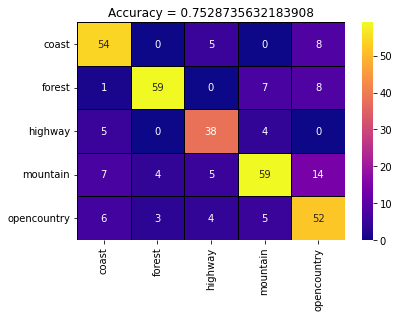

In [7]:
path = 'Assets/Image Dataset'
data_class = ['coast', 'forest', 'highway', 'mountain', 'opencountry']

C = [] #36*23
D = []

for i in data_class:
	C.append(read_ID(path, i, 'train').flatten().reshape(-1, 36*23))
	D.append(read_ID(path, i, 'dev').flatten().reshape(-1, 36*23))
C_y = []
D_y = []

for i in range(5):
	C_y.append(i * np.ones(C[i].shape[0]))
	D_y.append(i * np.ones(D[i].shape[0]))
train = np.concatenate(C, axis=0)
dev = np.concatenate(D, axis=0)

X = (train - train.min(axis=0))/(train.max(axis=0) - train.min(axis=0))
X_d = (dev - dev.min(axis=0))/(dev.max(axis=0) - dev.min(axis=0))
Y = np.concatenate(C_y, axis=0)
Y_d = np.concatenate(D_y, axis=0)
pca = False
lda = False
lda = ~pca & lda #if pca is true then lda is false
if pca:
	pc = 20
	μ, Σ = stats(X)
	eigval, Q = PCA(Σ, pc)
	X = X @ Q
	X_d = X_d @ Q
if lda:
	pc = 20
	μ, Σ = stats(X)
	μk = []
	for c in range(5):
		μk.append(stats(X[Y == c])[0])
	μk = np.array(μk)
	v = LDA(X,Y,μ,μk,pc)
	X = np.abs(X @ v)
	X_d = np.abs(X_d @ v)
classifier = Sequential()
classifier.add(Dense(512, input_shape=(X.shape[1],), kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(512, input_shape=(X.shape[1],), kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(5, kernel_initializer = 'uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.fit(X, label_binarize(Y, classes=[0,1,2,3,4]), batch_size = 50, epochs = 100)
y_pred = classifier.predict(X_d)
cm = confusion_matrix(np.argmax(y_pred,axis=1), Y_d)
accuracy = accuracy_score(Y_d,np.argmax(y_pred,axis=1))
ax = sns.heatmap(cm, annot = True, cmap ='plasma',linecolor ='black', linewidths = 1, fmt = '.0f', xticklabels = data_class, yticklabels = data_class)
ax.set_title(f'Accuracy = {accuracy}')
TPR_i4 = 0; FPR_i4 = 0
for c in range(5):
	tpr, fpr = ROC(label_binarize(Y_d, classes=[0,1,2,3,4])[:,c], y_pred[:,c])
	TPR_i4 += tpr/5
	FPR_i4 += fpr/5


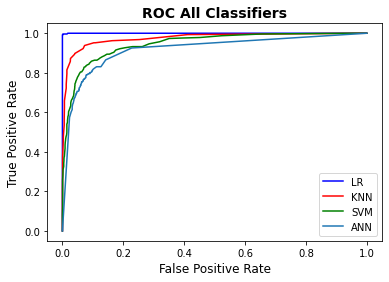

In [8]:
plt.plot(FPR_i1, TPR_i1, 'b')
plt.plot(FPR_i2, TPR_i2, 'r')
plt.plot(FPR_i3, TPR_i3, 'g')
plt.plot(FPR_i4, TPR_i4)
plt.xlabel('False Positive Rate',fontsize=12); plt.ylabel('True Positive Rate',fontsize=12)
plt.title('ROC All Classifiers',fontweight="bold", fontsize=14)
plt.legend(['LR', 'KNN', 'SVM', 'ANN'])